In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [ ]:
import os
os.makedirs('/content/drive/MyDrive/Deep learning project', exist_ok=True)


# **Convolutional Neural Networks (CNNs) ON CIFAR-10**

 We will build a Convolutional Neural Network (CNN) model to classify images from a cifar10 dataset into predefined categories. Then, they will implement a transfer learning approach using a pre-trained model. Finally, we will compare the performance of the custom CNN and the transfer learning model based on evaluation metrics and analysis.
#

 The dataset for this task is the CIFAR-10 dataset, which consists of 50,000 32x32 color images in 10 classes, with 5,000 images per class.

## 1. Load and Visualize Dataset

Fashion-MNIST is a dataset built to replace the classic MNIST handwritten digits. It includes:

50,000 training images

10,000 test images

10 random categories


In [ ]:
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

# Load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
print(X_train[0][0])       # First row of the first image (32 pixels, each with 3 RGB values)
print(y_train[0][0])       # Label of the first image (integer from 0 to 9)


[[ 59  62  63]
 [ 43  46  45]
 [ 50  48  43]
 [ 68  54  42]
 [ 98  73  52]
 [119  91  63]
 [139 107  75]
 [145 110  80]
 [149 117  89]
 [149 120  93]
 [131 103  77]
 [125  99  76]
 [142 115  91]
 [144 112  86]
 [137 105  79]
 [129  97  71]
 [137 106  79]
 [134 106  76]
 [124  97  64]
 [139 113  78]
 [139 112  75]
 [133 105  69]
 [136 105  74]
 [139 108  77]
 [152 120  89]
 [163 131 100]
 [168 136 108]
 [159 129 102]
 [158 130 104]
 [158 132 108]
 [152 125 102]
 [148 124 103]]
6


In [ ]:
import pandas as pd

df_labels = pd.DataFrame(y_train, columns=['label'])
print(df_labels.info())
print(df_labels.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   50000 non-null  uint8
dtypes: uint8(1)
memory usage: 49.0 KB
None
             label
count  50000.00000
mean       4.50000
std        2.87231
min        0.00000
25%        2.00000
50%        4.50000
75%        7.00000
max        9.00000


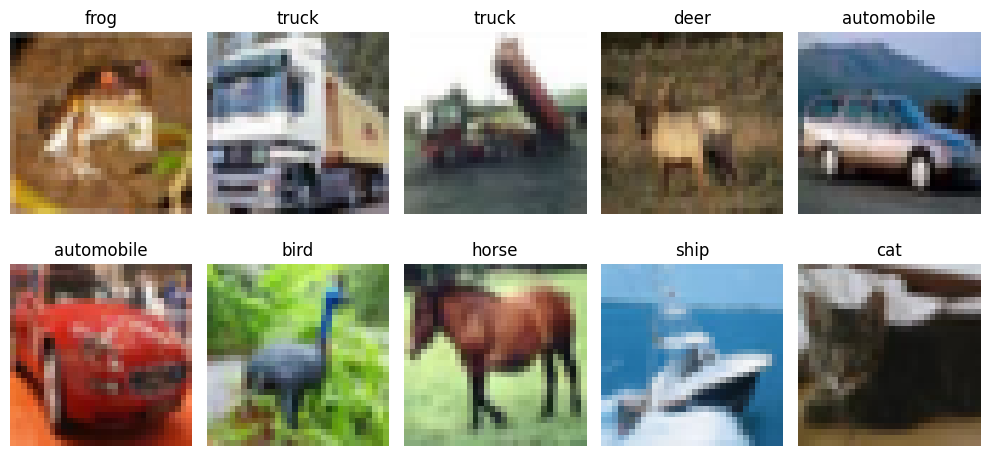

In [ ]:
# Visualize some examples
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(class_names[y_train[i][0]]) # or class_names[y_train[i].item()]
    plt.axis('off')
plt.tight_layout()
plt.show()

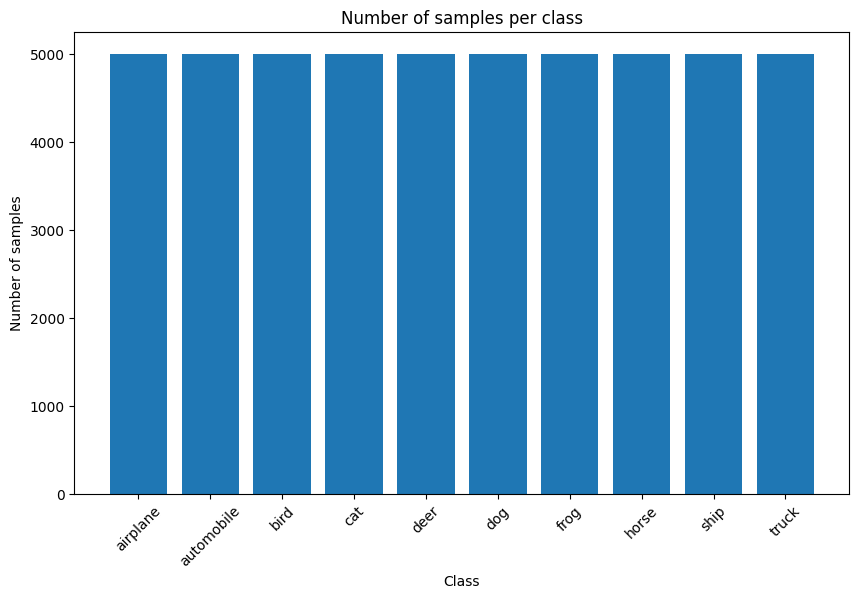

airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


In [ ]:

from collections import Counter


labels = y_train.flatten()

# Count the number of samples per class
class_counts = Counter(labels)

# Sort by class index
classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]


# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Number of samples per class')
plt.xticks(rotation=45)
plt.show()

# Optional: print counts for reference
for cls, count in zip(class_names, counts):
    print(f"{cls}: {count}")


## 2. Data Preprocessing

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Rescaling
import tensorflow as tf

# Reshape to add channel dimension
X_train = X_train.reshape(-1, 32, 32, 3)
X_test = X_test.reshape(-1, 32, 32, 3)

# Convert labels to one-hot vectors
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

# Create a preprocessing layer for normalization
normalization_layer = Rescaling(1./255)
X_train = normalization_layer(X_train)
X_test = normalization_layer(X_test)


Baseline CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy

def train_model(X_train, y_train, X_val=None, y_val=None, loss = categorical_crossentropy, epochs=10, batch_size=64, callbacks=None):
    is_one_hot = len(y_train.shape) == 2 and y_train.shape[1] > 1

    if is_one_hot:
        loss_fn = categorical_crossentropy
        print("Detected one-hot labels → using categorical_crossentropy")
    else:
        loss_fn = sparse_categorical_crossentropy
        print("Detected integer labels → using sparse_categorical_crossentropy")

    # Build a simple CNN
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val) if X_val is not None else None,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks
    )

    return model, history


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_1 = ModelCheckpoint(
    '/content/drive/MyDrive/Deep learning project/simple_cnnmodel_categoricalentropy.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

print("Saving model to:", checkpoint_1.filepath)

model, history = train_model(
    X_train, y_train_cat,
    X_val=X_test, y_val=y_test_cat,
    loss='categorical_crossentropy',
    epochs=10,
    batch_size=64,
    callbacks=[checkpoint_1]
)

Saving model to: /content/drive/MyDrive/Deep learning project/simple_cnnmodel_categoricalentropy.keras
Detected one-hot labels → using categorical_crossentropy
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3768 - loss: 1.7224
Epoch 1: val_accuracy improved from -inf to 0.56800, saving model to /content/drive/MyDrive/Deep learning project/simple_cnnmodel_categoricalentropy.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3769 - loss: 1.7221 - val_accuracy: 0.5680 - val_loss: 1.2273
Epoch 2/10
771/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5913 - loss: 1.1595
Epoch 2: val_accuracy improved from 0.56800 to 0.61560, saving model to /content/drive/MyDrive/Deep learning project/simple_cnnmodel_categoricalentropy.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5915 - loss: 1.1589 - val_accuracy: 0.6156 - val_loss: 1.0956
Epoch 3/10
776/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6570 - loss: 0.9851
Epoch 3: val_accuracy improved from 0.61560 to 0.64930, saving model to /content/drive/MyDrive/Deep learning project/simple_cnnmodel_categoricalentropy.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accur

In [ ]:
model.save("/content/drive/MyDrive/Deep learning project/simple_cnnmodel.keras")
from google.colab import files
files.download("/content/drive/MyDrive/Deep learning project/simple_cnnmodel.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
print(os.path.exists('/content/drive/MyDrive/Deep learning project/simple_cnnmodel_categoricalentropy.keras'))


True


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

with open("training_history.json", "w") as f:
    json.dump(history.history, f)

y_pred = model.predict(X_test)
np.save("predictions.npy", y_pred)

# Download to your local computer
files.download("predictions.npy")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

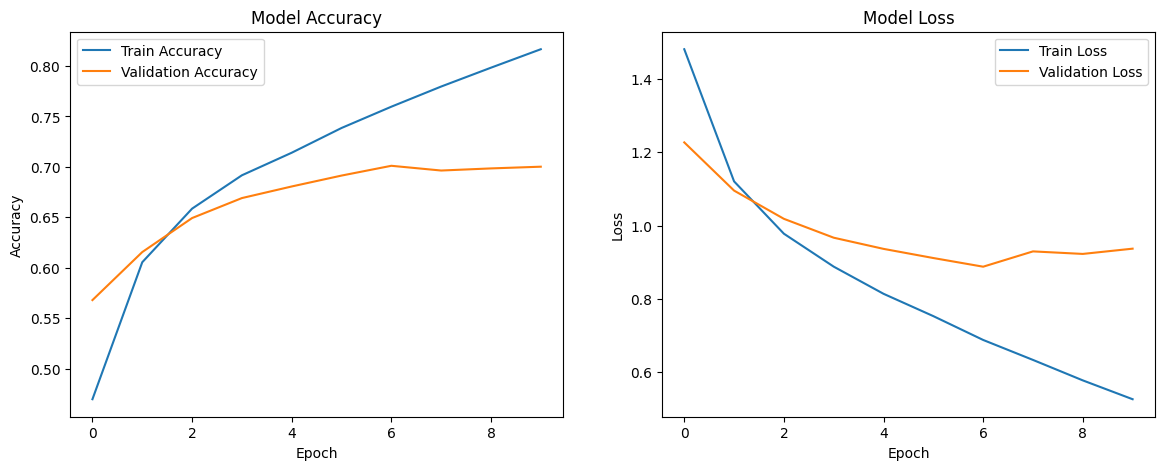

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(14,5))

    # Plot accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Example usage after training
plot_training_history(history)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 947,168 (3.61 MB)

 Trainable params: 315,722 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 631,446 (2.41 MB)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class predictions
y_pred = y_pred_probs.argmax(axis=1)

# Assuming y_test_cat is one-hot encoded
y_true = np.argmax(y_test_cat, axis=1)

# Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Test Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test Accuracy: 0.7002
Precision: 0.7010
Recall: 0.7002
F1 Score: 0.6984


              precision    recall  f1-score   support

    airplane       0.76      0.76      0.76      1000
  automobile       0.73      0.84      0.78      1000
        bird       0.55      0.68      0.60      1000
         cat       0.58      0.48      0.52      1000
        deer       0.66      0.61      0.64      1000
         dog       0.65      0.56      0.60      1000
        frog       0.78      0.77      0.77      1000
       horse       0.72      0.75      0.74      1000
        ship       0.84      0.77      0.80      1000
       truck       0.75      0.78      0.76      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



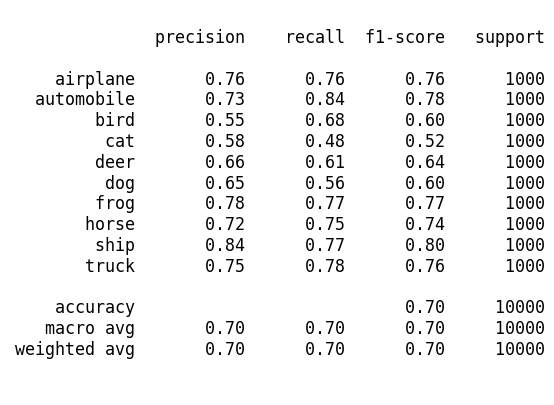

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Plot text
plt.figure(figsize=(6,5))
plt.text(0.01, 0.05, report, fontsize=12, fontfamily='monospace')
plt.axis('off')

# Save as PNG
plt.savefig("classification_report.png", bbox_inches="tight")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


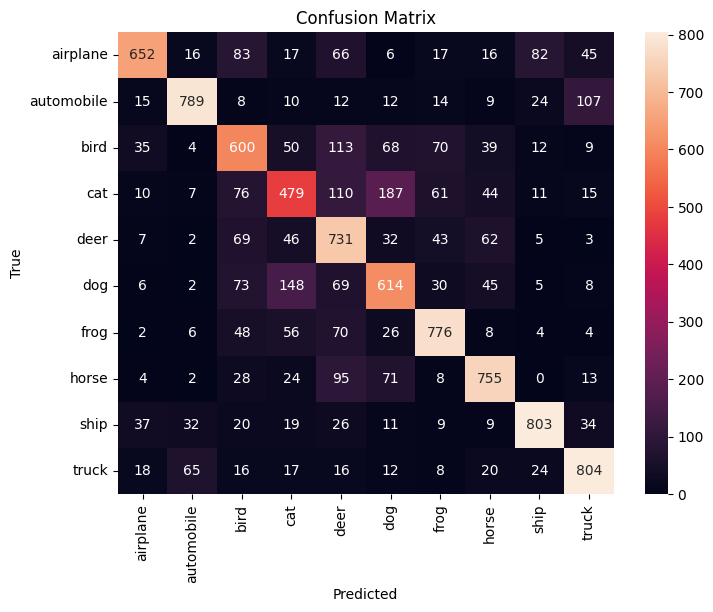

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict & confusion matrix
y_pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


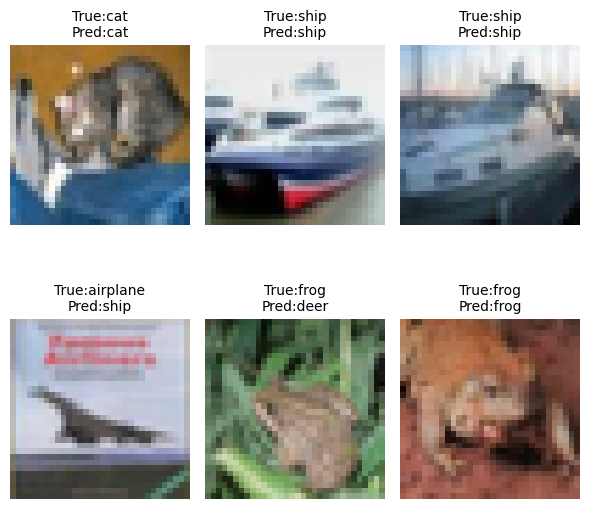

In [ ]:
import matplotlib.pyplot as plt

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

def plot_grid(X, y_true, y_pred, class_names, rows=3, cols=3):
    plt.figure(figsize=(6,6))
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.imshow(X[i])
        plt.title(f"True:{class_names[y_true[i]]}\nPred:{class_names[y_pred[i]]}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
plot_grid(X_test, y_true, y_pred, class_names, rows=2, cols=3)


### Optimized (complex) CNN Model
New model but with sparse entropy and no one hot encoding

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization,
    RandomFlip, RandomRotation, RandomZoom, RandomTranslation # Added RandomTranslation
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping # Removed ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import joblib
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="keras")

def train_improved_cnn(
    X_train, y_train, X_val=None, y_val=None,
    epochs=150, batch_size=128, initial_lr=0.001,
    conv_filters=[64, 128, 256], dropout_clf=0.5,
    augment=True, verbose=1, extra_callbacks=None
):
    # -------------------------------------------------
    # 1. Detect loss automatically
    # -------------------------------------------------
    is_one_hot = len(y_train.shape) == 2 and y_train.shape[1] > 1
    loss_name = 'categorical_crossentropy' if is_one_hot else 'sparse_categorical_crossentropy'
    print(f"Using loss: {loss_name}")

    # -------------------------------------------------
    # 2. On-the-fly augmentation (no generator warning)
    # -------------------------------------------------
    data_aug = tf.keras.Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.15),
        RandomZoom(0.15),
        tf.keras.layers.RandomTranslation(0.1, 0.1)
    ]) if augment else None

    # -------------------------------------------------
    # 3. Model – deeper, wider, regularised
    # -------------------------------------------------
    inputs = tf.keras.Input(shape=X_train.shape[1:])
    x = inputs
    if data_aug:
        x = data_aug(x, training=True)

    for f in conv_filters:
        x = Conv2D(f, 3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2D(f, 3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(2, 2)(x)
        x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_clf)(x)
    outputs = Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    # -------------------------------------------------
    # 4. Cosine-decay LR schedule
    # -------------------------------------------------
    steps_per_epoch = len(X_train) // batch_size
    lr_schedule = CosineDecay(initial_learning_rate=initial_lr,
                              decay_steps=epochs * steps_per_epoch)

    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss=loss_name,
        metrics=['accuracy']
    )

    # -------------------------------------------------
    # 5. Callbacks
    # -------------------------------------------------
    callbacks = [
        # Removed ReduceLROnPlateau as it conflicts with CosineDecay schedule
        EarlyStopping(monitor='val_loss', patience=15,
                      restore_best_weights=True, verbose=verbose)
    ]
    if extra_callbacks:
        callbacks.extend(extra_callbacks)   # add your checkpoint here

    # -------------------------------------------------
    # 6. Train
    # -------------------------------------------------
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val) if X_val is not None else None,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose
    )

    # -------------------------------------------------
    # 7. Save model + tiny config (so loading never fails)
    # -------------------------------------------------
    model.save("cnn_90plus.keras")
    joblib.dump({
        'initial_lr': initial_lr,
        'epochs': epochs,
        'batch_size': batch_size,
        'X_train_len': len(X_train),
        'label_mode': 'integer' if not is_one_hot else 'one_hot'
    }, "cnn_90plus_config.pkl")

    return model, history

In [ ]:
''' from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_2_impr = ModelCheckpoint(
    '/content/drive/MyDrive/Deep learning project/improved_cnnmodel_categoricalentropy.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
) '''

print("Saving model to:", checkpoint_2_impr.filepath)

model_improved, hist_improved = train_improved_cnn(
    X_train, y_train,
    X_val=X_test, y_val=y_test,
    epochs=150,
    batch_size=128,
    initial_lr=0.001,
    conv_filters=[64, 128, 256],
    dropout_clf=0.5,
    augment=True,
    verbose=1
    # extra_callbacks=[checkpoint_2_impr]
)


Saving model to: /content/drive/MyDrive/Deep learning project/improved_cnnmodel_categoricalentropy.keras
Using loss: sparse_categorical_crossentropy
Epoch 1/150
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3123 - loss: 2.2320
Epoch 1: val_accuracy improved from -inf to 0.21180, saving model to /content/drive/MyDrive/Deep learning project/improved_cnnmodel_categoricalentropy.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.3125 - loss: 2.2312 - val_accuracy: 0.2118 - val_loss: 2.8253
Epoch 2/150
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4671 - loss: 1.4979
Epoch 2: val_accuracy improved from 0.21180 to 0.41610, saving model to /content/drive/MyDrive/Deep learning project/improved_cnnmodel_categoricalentropy.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.4673 - loss: 1.4975 - val_accuracy: 0.4161 - val_loss: 1.8669
Epoch 3/150
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5364 - loss: 1.2953
Epoch 3: val_accuracy improved f

In [ ]:
# -------------------------------------------------
#  Final accuracy
# -------------------------------------------------
loss, acc = model_improved.evaluate(X_test, y_test, verbose=0)
print(f"\nFINAL TEST ACCURACY: {acc:.4f}  ({acc*100:.2f} %)")


FINAL TEST ACCURACY: 0.8853  (88.53 %)


In [ ]:
# Save to Drive (for backup)
model_improved.save('/content/drive/MyDrive/Deep learning project/improved_sparsed_simple_cnnmodel.keras')

# Download to your laptop
from google.colab import files
files.download('/content/drive/MyDrive/Deep learning project/improved_sparsed_simple_cnnmodel.keras')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

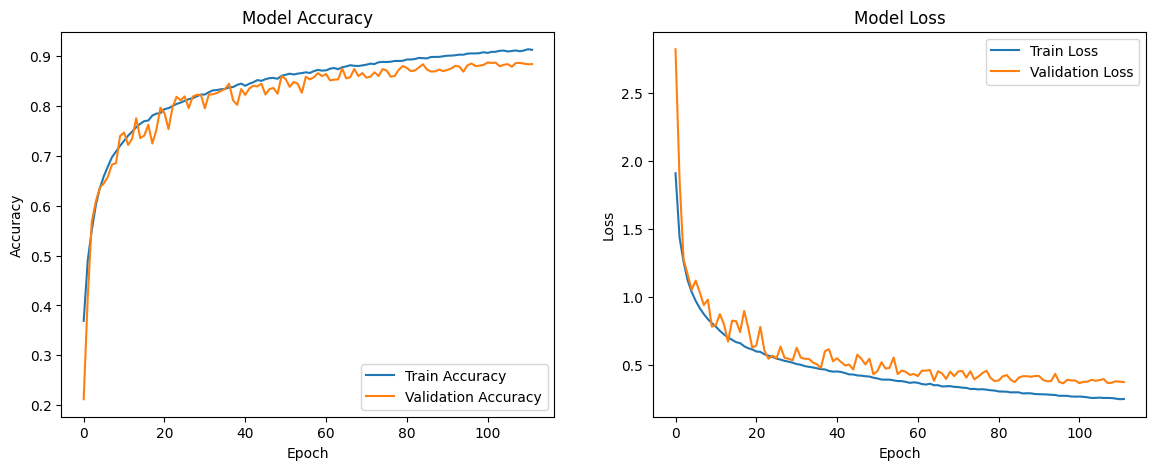

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(14,5))

    # Plot accuracy
    plt.subplot(1,2,1)
    plt.plot(hist_improved.history['accuracy'], label='Train Accuracy')
    plt.plot(hist_improved.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1,2,2)
    plt.plot(hist_improved.history['loss'], label='Train Loss')
    plt.plot(hist_improved.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Example usage after training
plot_training_history(hist_improved)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

    airplane       0.90      0.89      0.90      1000
  automobile       0.91      0.97      0.94      1000
        bird       0.87      0.83      0.85      1000
         cat       0.84      0.77      0.80      1000
        deer       0.91      0.84      0.87      1000
         dog       0.87      0.80      0.83      1000
        frog       0.82      0.96      0.88      1000
       horse       0.90      0.93      0.92      1000
        ship       0.93      0.94      0.94      1000
       truck       0.90      0.92      0.91      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.88     10000
weighted avg       0.89      0.89      0.88     10000



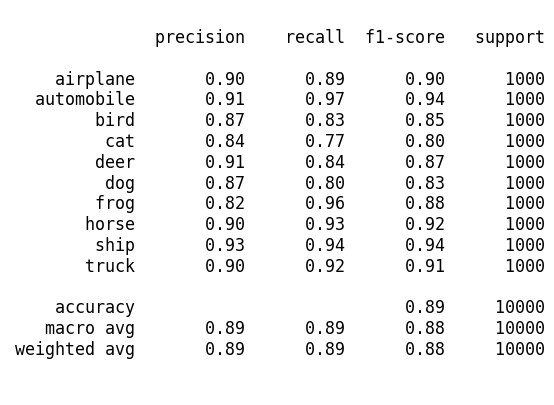

In [ ]:
from sklearn.metrics import classification_report

# Predict class probabilities
y_pred_improved = model_improved.predict(X_test)

# Convert probabilities to class predictions
y_pred_improved = y_pred_improved.argmax(axis=1)

# Assuming y_test_cat is one-hot encoded
y_true_improved = y_test

report1 = classification_report(y_true_improved, y_pred_improved, target_names=class_names)
print(report1)

# Plot text
plt.figure(figsize=(6,5))
plt.text(0.01, 0.05, report1, fontsize=12, fontfamily='monospace')
plt.axis('off')

# Save as PNG
plt.savefig("classification_report_improved.png", bbox_inches="tight")
plt.show()

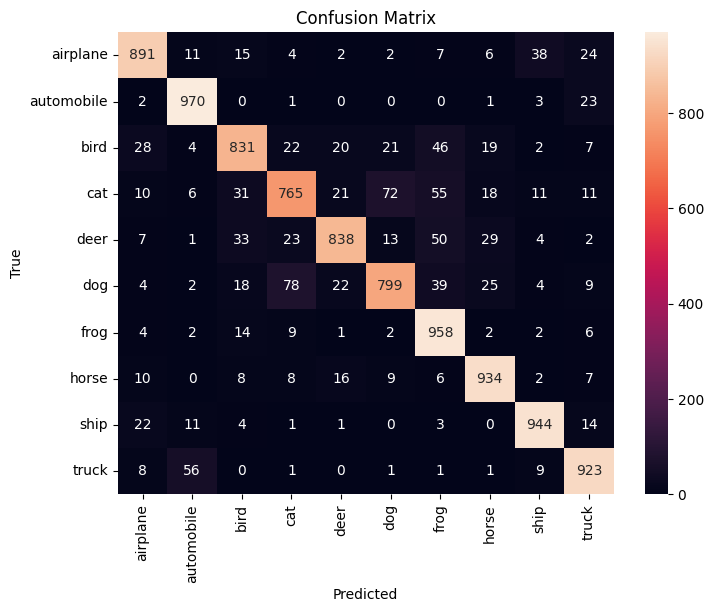

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_pred_improved)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


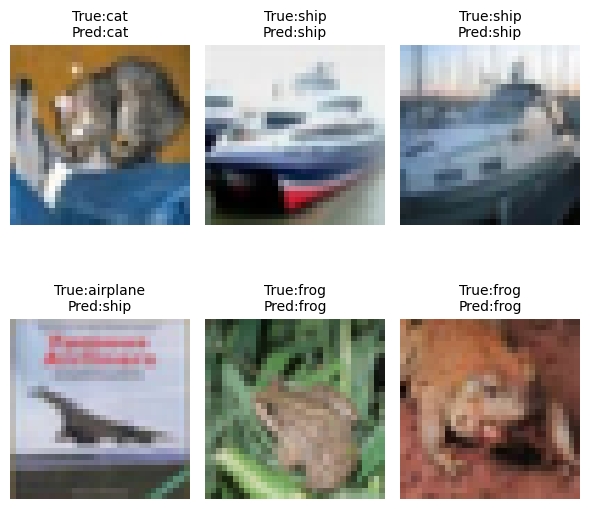

In [ ]:
import matplotlib.pyplot as plt

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

def plot_grid(X, y_true, y_pred, class_names, rows=3, cols=3):
    plt.figure(figsize=(6,6))
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.imshow(X[i])
        plt.title(f"True:{class_names[y_true[i][0]]}\nPred:{class_names[y_pred[i]]}", fontsize=10) # Fixed indexing here
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
plot_grid(X_test, y_true_improved, y_pred_improved, class_names, rows=2, cols=3)

Optimized (complex) CNN Model

Same as above model but with Cross entropy and did one hot encoding on y_test and y_train

In [ ]:
# ================================
#  CNN – STABLE, FAST, SIMPLE
# ================================
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization,
                                     RandomFlip, RandomRotation, RandomZoom)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import joblib
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# --- ENABLE MIXED PRECISION (BIG WIN) ---
tf.keras.mixed_precision.set_global_policy('mixed_float16')

def train_optimized_cnn(
    X_train, y_train, X_val=None, y_val=None,
    epochs=150, batch_size=128, initial_lr=0.001,
    conv_filters=[64, 128, 256], dropout_clf=0.5,
    augment=True, verbose=1, extra_callbacks = None
):
    # --- 1. Auto-detect loss (NO label smoothing) ---
    is_one_hot = len(y_train.shape) == 2 and y_train.shape[1] > 1
    loss_name = 'categorical_crossentropy' if is_one_hot else 'sparse_categorical_crossentropy'
    print(f"Using: {loss_name} | Mixed Precision: ON")

    # --- 2. MILD augmentation ---
    data_aug = tf.keras.Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),
    ]) if augment else None

    # --- 3. Model (same as your 89.13% one) ---
    inputs = tf.keras.Input(shape=X_train.shape[1:])
    x = inputs
    if data_aug:
        x = data_aug(x, training=True)

    for f in conv_filters:
        x = Conv2D(f, 3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2D(f, 3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(2, 2)(x)
        x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_clf)(x)
    outputs = Dense(10, activation='softmax', dtype='float32')(x)  # ← float32 for stability

    model = tf.keras.Model(inputs, outputs)

    # --- 4. Cosine Decay (no restarts) ---
    steps_per_epoch = len(X_train) // batch_size
    lr_schedule = CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=epochs * steps_per_epoch
    )

    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss=loss_name,
        metrics=['accuracy']
    )

    # --- 5. Callbacks ---
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=verbose)
    ]
    if extra_callbacks:
        callbacks.extend(extra_callbacks)    # add your checkpoint here

    # --- 6. Train ---
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose
    )

    # --- 7. Save ---
    model.save("cnn_91plus.keras")
    joblib.dump({
        'initial_lr': initial_lr,
        'epochs': epochs,
        'batch_size': batch_size,
        'X_train_len': len(X_train),
        'label_mode': 'integer' if not is_one_hot else 'one_hot'
    }, "cnn_91plus_config.pkl")

    return model, history

In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint_3_opti = ModelCheckpoint(
#     '/content/drive/MyDrive/Deep learning project/improved_cnnmodel_categoricalentropy.keras',
#     monitor='val_accuracy',
#     save_best_only=True,
#     verbose=1
# )

# print("Saving model to:", checkpoint_3_opti.filepath)

# TRAIN
model_optimized, hist_optimized = train_optimized_cnn(
    X_train, y_train_cat,
    X_val=X_test, y_val=y_test_cat,
    epochs=150,
    batch_size=128,
    augment=True,
    verbose=1/,
    # extra_callbacks=[checkpoint_3_opti]
)


Saving model to: /content/drive/MyDrive/Deep learning project/improved_cnnmodel_categoricalentropy.keras
Using: categorical_crossentropy | Mixed Precision: ON
Epoch 1/150
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3417 - loss: 2.1340
Epoch 1: val_accuracy improved from -inf to 0.26510, saving model to /content/drive/MyDrive/Deep learning project/improved_cnnmodel_categoricalentropy.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 74s 92ms/step - accuracy: 0.3419 - loss: 2.1331 - val_accuracy: 0.2651 - val_loss: 2.3893
Epoch 2/150
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5342 - loss: 1.3208
Epoch 2: val_accuracy improved from 0.26510 to 0.63020, saving model to /content/drive/MyDrive/Deep learning project/improved_cnnmodel_categoricalentropy.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.5344 - loss: 1.3202 - val_accuracy: 0.6302 - val_loss: 1.0742
Epoch 3/150
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6238 - loss: 1.0648
Epoch 3: val_accuracy 

In [ ]:
loss, acc = model_optimized.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nFINAL TEST ACCURACY: {acc:.4f} ({acc*100:.2f}%)")


FINAL TEST ACCURACY: 0.9032 (90.32%)


In [ ]:
# Save to Drive (for backup)
model_optimized.save('/content/drive/MyDrive/Deep learning project/optimized_categorical_cnnmodel.keras')

# Download to your laptop
from google.colab import files
files.download('/content/drive/MyDrive/Deep learning project/optimized_categorical_cnnmodel.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

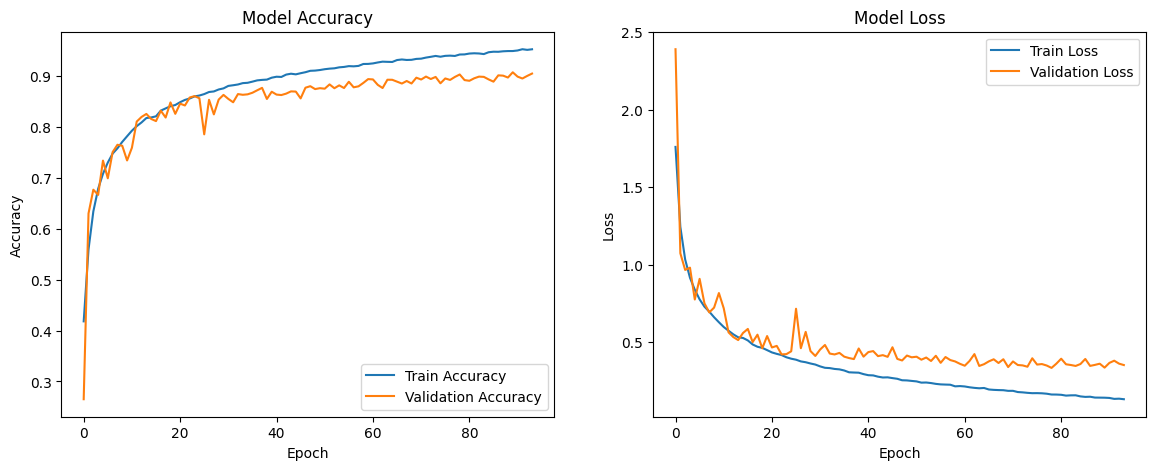

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(14,5))

    # Plot accuracy
    plt.subplot(1,2,1)
    plt.plot(hist_optimized.history['accuracy'], label='Train Accuracy')
    plt.plot(hist_optimized.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1,2,2)
    plt.plot(hist_optimized.history['loss'], label='Train Loss')
    plt.plot(hist_optimized.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Example usage after training
plot_training_history(hist_optimized)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

    airplane       0.91      0.93      0.92      1000
  automobile       0.93      0.97      0.95      1000
        bird       0.91      0.85      0.88      1000
         cat       0.81      0.82      0.81      1000
        deer       0.89      0.90      0.90      1000
         dog       0.89      0.82      0.85      1000
        frog       0.91      0.95      0.93      1000
       horse       0.93      0.93      0.93      1000
        ship       0.93      0.94      0.94      1000
       truck       0.92      0.94      0.93      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



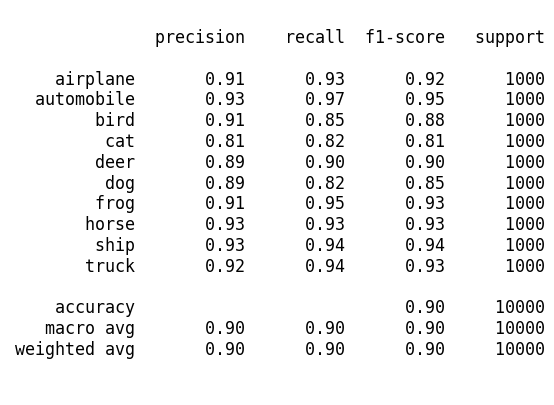

In [ ]:
from sklearn.metrics import classification_report

# Predict class probabilities
y_pred_optimized = model_optimized.predict(X_test)

# Convert probabilities to class predictions
y_pred_optimized = y_pred_optimized.argmax(axis=1)

# Assuming y_test_cat is one-hot encoded
y_true_optimized = np.argmax(y_test_cat, axis=1)

report2 = classification_report(y_true_optimized, y_pred_optimized, target_names=class_names)
print(report2)

# Plot text
plt.figure(figsize=(6,5))
plt.text(0.01, 0.05, report2, fontsize=12, fontfamily='monospace')
plt.axis('off')

# Save as PNG
plt.savefig("classification_report_optimized.png", bbox_inches="tight")
plt.show()

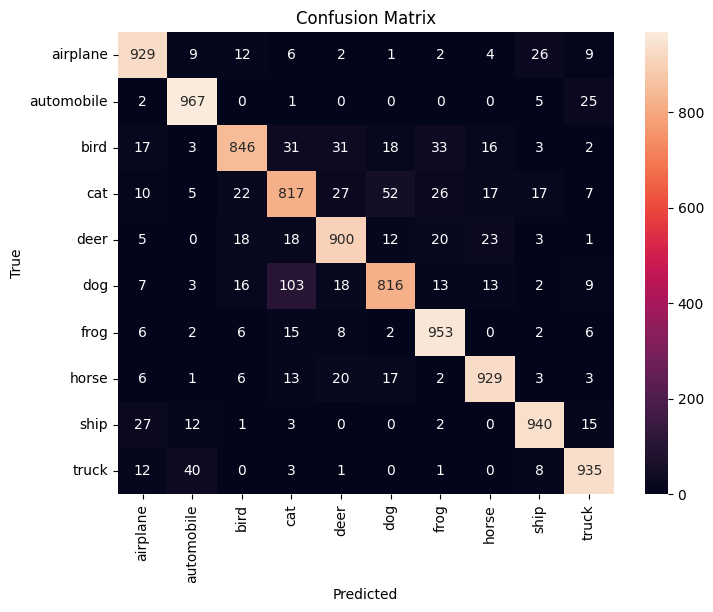

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_true_optimized, y_pred_optimized)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


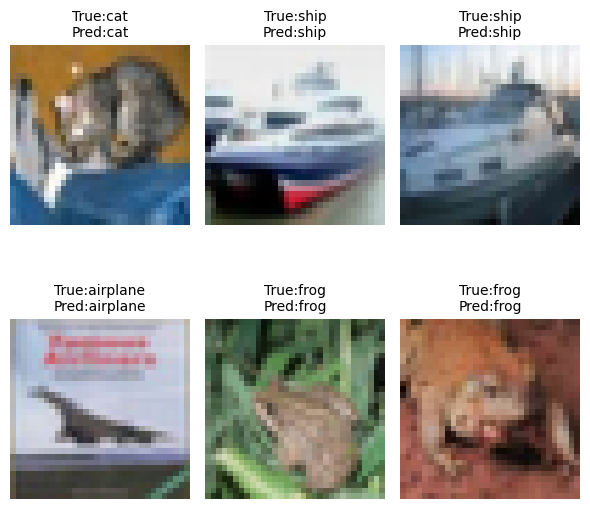

In [ ]:
import matplotlib.pyplot as plt

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

def plot_grid(X, y_true, y_pred, class_names, rows=3, cols=3):
    plt.figure(figsize=(6,6))
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.imshow(X[i])
        plt.title(f"True:{class_names[y_true[i]]}\nPred:{class_names[y_pred[i]]}", fontsize=10) # Fixed indexing here
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
plot_grid(X_test, y_true_optimized, y_pred_optimized, class_names, rows=2, cols=3)